In [1]:
import argparse
import os
import numpy as np
from keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import struct
import cv2

Using TensorFlow backend.


In [2]:
from keras.layers import Reshape

In [3]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'], 
                   conv['kernel'], 
                   strides=conv['stride'], 
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']), 
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [4]:
def make_yolov3_model(num_boxes,num_classes):
    input_image = Input(shape=(96, 128, 3))

    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])

    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])

    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])

    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])

    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
        
    skip_36 = x
        
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])

    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
        
    skip_61 = x
        
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])

    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
        
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)

    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter': num_boxes*(5+num_classes), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)

    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])

    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)

    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': num_boxes*(5+num_classes), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)

    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])

    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': num_boxes*(5+num_classes), 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    
    
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])    
    return model

In [5]:
model = make_yolov3_model(1,4)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, 96, 128, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, 96, 128, 32)  128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, 96, 128, 32)  0           bnorm_0[0][0]                    
____________________________________________________________________________________________

In [6]:
X = np.load("TrainingData/yolo_X.npy")

labels = np.load("TrainingData/yolo_labels.npy")

gt_coords = np.load("TrainingData/yolo_gt_coords.npy")
labels.shape

(8675,)

In [7]:
output_dims = [(3,4),(6,8),(12,16)]

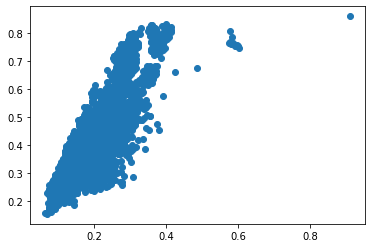

array([[0.30114275, 0.66998938],
       [0.2202595 , 0.45236526],
       [0.15032819, 0.31072583]])

In [8]:
## Kmeans to find centroids

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.scatter(gt_coords[:,2],gt_coords[:,3])
plt.show()

kmeans = KMeans(n_clusters=3, random_state=7).fit(gt_coords[:,2:4])

anchors = kmeans.cluster_centers_

anchors = anchors[::-1,:]# decreasing order of size

anchors

In [9]:
from YoloUtils import *

yolo_y1 = []
yolo_y2 = []
yolo_y3 = []
for i in range(X.shape[0]):
    a = get_y_true(X[i],labels[i],gt_coords[i],4,output_dims,anchors,0.5)
    yolo_y1.append(a[0])
    yolo_y2.append(a[1])
    yolo_y3.append(a[2])

In [10]:
y1 = np.array(yolo_y1)
y2 = np.array(yolo_y2)
y3 = np.array(yolo_y3)

In [11]:
from YoloLoss import *

model.compile(optimizer='adam',loss = Loss)

Tensor("loss/conv_81_loss/Loss/Shape_1:0", shape=(4,), dtype=int32)
Tensor("loss/conv_81_loss/Loss/add:0", shape=(None, 3, 4, None), dtype=float32)
Tensor("loss/conv_81_loss/Loss/Shape_2:0", shape=(4,), dtype=int32)
Tensor("loss/conv_81_loss/Loss/add_1:0", shape=(None, 3, 4, None), dtype=float32)
Tensor("loss/conv_81_loss/Loss/Shape_3:0", shape=(4,), dtype=int32)
Tensor("loss/conv_81_loss/Loss/add_2:0", shape=(None, 3, 4, 4), dtype=float32)
Tensor("loss/conv_93_loss/Loss/Shape_1:0", shape=(4,), dtype=int32)
Tensor("loss/conv_93_loss/Loss/add:0", shape=(None, 6, 8, None), dtype=float32)
Tensor("loss/conv_93_loss/Loss/Shape_2:0", shape=(4,), dtype=int32)
Tensor("loss/conv_93_loss/Loss/add_1:0", shape=(None, 6, 8, None), dtype=float32)
Tensor("loss/conv_93_loss/Loss/Shape_3:0", shape=(4,), dtype=int32)
Tensor("loss/conv_93_loss/Loss/add_2:0", shape=(None, 6, 8, 4), dtype=float32)
Tensor("loss/conv_105_loss/Loss/Shape_1:0", shape=(4,), dtype=int32)
Tensor("loss/conv_105_loss/Loss/add:0", s

In [12]:
from sklearn.utils import shuffle
X, y1, y2, y3 = shuffle(X, y1, y2, y3, random_state=0)

In [13]:
y3.shape

(8675, 12, 16, 9)

In [15]:
y = {'conv_81':y1, 'conv_93':y2, 'conv_105':y3}

In [ ]:
model.fit(X,y,batch_size=32,epochs=1,validation_split=0.15)

Train on 7373 samples, validate on 1302 samples
Epoch 1/1
  32/7373 [..............................] - ETA: 1:35:05 - loss: 25618.6719 - conv_81_loss: 610.9106 - conv_93_loss: 13129.6787 - conv_105_loss: 11878.0830